

```
--- 
title: "Shipyard's Analytic Exercise" 
author: 
 - Guilherme Gonçalves de Lima 
created_at: 2020-07-07 00:00:00 
updated_at: 2020-07-08 00:00:00 
tags: 
 - shipyard interview 
 - interview test 
 - eda 
 - logistic regression 
tldr: 
--- 
```



# 1. Introduction

This report provide answers to analytic exercise. The goal of this study is to identifify the touchpoints, or combination of touchpoints, that increase the likelihood of conversions (i.e., purchases) and to recommend some next steps a potencial client might take.

## Importing packages and functions

In [ ]:
# !pip install plotnine
# !pip install statsmodels==0.11.1

In [ ]:
from google.colab import files

# Upload dataset
uploaded = files.upload()

In [ ]:
# Data analysis and manipulation tools
import pandas as pd
import numpy as np

# Data Visualization
from plotnine import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
%matplotlib inline

# Statistical models and tests
from statsmodels.stats.stattools import jarque_bera
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats

In [ ]:
def custom_normality_test(x):
    ''' Function to test for normality using Jarque-Bera test

        # Arguments:
            x: data to test for normality.
        # Returns:
            Dict with statistics.
    '''
    norm_test_labels = ['jb_stat', 'jb_pvalue', 'skew', 'kurtosis']
    result = dict(zip(
        norm_test_labels,
        np.round(jarque_bera(x), 6)
    ))
    return result

def custom_or_model(model, decimals=3):
    ''' Function to return Odds Ratio of Logistic Regression

        # Arguments:
            model: statsmodels object.
            decimals: number of decimal places to round to. Default 3.
        # Returns:
            Dataframe with statistics.
    '''
    or_model = pd.concat(
        [pd.DataFrame(model.params).rename(columns={0: 'Coef.'}),
        model.conf_int().rename(columns={0: '2.5%', 1: '97.5%'})],
        axis=1
    )
    return np.round(np.exp(or_model), decimals)

def custom_table(df, variable):
    ''' Function to return table with counts and percentage

        # Arguments:
            df: pandas dataframe.
            variable: name of column.
        # Returns:
            Dataframe with statistics.
    '''
    return pd.concat(
        [df[variable].value_counts(),
         df[variable].value_counts(normalize=True).mul(100).round(2)],
        axis=1, names=variable, keys=('counts','percentage'), sort=True
    )

def custom_corr_plot(df, title):
    ''' Custom Correlation plot

        Pairwise Pearson's correlation matrix
        Strength of correlation :
            .00-.19 “very weak”
            .20-.39 “weak”
            .40-.59 “moderate”
            .60-.79 “strong”
            .80-1.0 “very strong”
        
        # Arguments:
            df: dataframe.
            title: title of chart.
        # Returns:
            matplotlib object.
    '''
    df_corr = df.corr(method='pearson').round(3)

    # Mask for Correlation Matrix plot
    mask = np.zeros_like(df_corr)
    mask[np.triu_indices_from(mask)] = True

    # Remove first row and last column
    df_corr = (
        df_corr
        .drop('a_direct', axis=0)
        .drop('h_conversion', axis=1)
    )
    mask = mask[1:, :-1]

    # Columns labels dict
    columns_labels_dict = {
        'a_direct': 'Direct',
        'b_display': 'Display',
        'c_email': 'Email',
        'd_search': 'Search',
        'e_social': 'Social',
        'f_referral': 'Referral',
        'g_video': 'Video',
        'h_conversion': 'Conversion',
    }

    # Plot
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(12.5, 5.5))
    ax = sns.heatmap(df_corr, 
                     xticklabels=[columns_labels_dict[c] for c in df_corr.columns.values], 
                     yticklabels=[columns_labels_dict[c] for c in df_corr.index.values],
                     cmap=sns.diverging_palette(20, 200, sep=20, as_cmap=True),
                     center=0, vmin=-1, vmax=1, mask=mask, linewidths=.01, linecolor='#cbcbcb', 
                     annot=True)
    plt.xticks(rotation=45)
    # Title
    plt.gcf().text(0.09, 1, title, fontsize=20, weight='bold', alpha=.8)
    plt.gcf().text(0.09, .94, "Pearson's correlation", fontsize=15, alpha=.8)
    plt.tight_layout(pad=3)
    return plt

# **Dataset**

The simplified data set only has 3 variables: 

1.   **UUID** = A unique identifier for each customer in the data set. Can have multiple rows per UUID. 

2.   **Event** = The character name of the touchpoint the customer was exposed to or interacted with. This variable has a total of 8 values:


```
a. Direct = Customer navigated directly to the client’s website.
b. Display = Exposure to a display or banner ad.
c. Email = Customer received an email promotion from the client. 
d. Search = Customer used a search term tracked by the client. 
e. Social = Customer saw an advertisement on a social network platform (e.g., Facebook). 
f. Referral = Customer clicked on a link from a partner site that sent them to the client site. 
g. Video = Customer watched a client’s online video. 
h. Conversion = Customer bought a product on the client’s website.
```



3.   **Value** = The lifetime number of interactions with an Event type. 

In [ ]:
# Load data
df_simplified = pd.read_csv('./data/Analyst Case Study Data.csv')

This dataset contains 3 variables (2 categorical and 1 continous). There is no missing values.

In [ ]:
# Concise summary of a DataFrame
df_simplified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   UUID    400000 non-null  int64 
 1   Event   400000 non-null  object
 2   value   400000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.2+ MB


In [ ]:
# First rows of the ordered dataset
df_simplified.sort_values(['UUID', 'Event']).head(n=9)

,UUID,Event,value
13052,10001018,Direct,1
63052,10001018,Display,29
113052,10001018,Email,6
263052,10001018,Referral,1
163052,10001018,Search,4
213052,10001018,Social,4
313052,10001018,Video,0
363052,10001018,conversion,0
10886,10001042,Direct,11


In [ ]:
# Counting the number of customers
print(
    f'Total unique ID: {len(np.unique(df_simplified["UUID"].values)):,}'
)

Total unique ID: 50,000


In [ ]:
# Checking events
df_simplified['Event'].value_counts().to_dict()

{'Direct': 50000,
 'Display': 50000,
 'Email': 50000,
 'Referral': 50000,
 'Search': 50000,
 'Social': 50000,
 'Video': 50000,
 'conversion': 50000}

In [ ]:
# Checking how many events per user
(
 df_simplified
 .groupby('UUID')
 .size()
 .reset_index(name='total')['total']
 .value_counts()
 .to_dict()
)

{8: 50000}

In [ ]:
# Transforming factors
event_factors = {
    'Direct': 'a_direct',
    'Display': 'b_display',
    'Email': 'c_email',
    'Search': 'd_search',
    'Social': 'e_social',
    'Referral': 'f_referral',
    'Video': 'g_video',
    'conversion': 'h_conversion',
}
df_simplified.replace(to_replace=event_factors, inplace=True)

Each user has the 8 event and the number of interactions with it. Then we can reshape the dataset as:





In [ ]:
# Reshaping dataset
df = df_simplified.pivot(index='UUID', columns='Event', values='value')

In [ ]:
# Create binary indicator
df['h_conversion_binary'] = df['h_conversion'].map(lambda x: '1' if x > 0 else '0')

In [ ]:
df

Event,a_direct,b_display,c_email,d_search,e_social,f_referral,g_video,h_conversion,h_conversion_binary
UUID,,,,,,,,,
10001018,1,29,6,4,4,1,0,0,0
10001042,11,19,5,8,4,1,0,4,1
10001178,11,5,3,3,8,0,0,5,1
10002831,4,17,3,9,8,1,1,0,0
10004423,3,0,3,8,7,1,1,0,0
...,...,...,...,...,...,...,...,...,...
99990774,3,30,4,6,5,0,1,7,1
99992491,9,0,3,3,5,2,1,0,0
99994021,6,0,6,6,5,1,1,0,0


# EDA

## Tables

In [ ]:
# Table
custom_table(df, 'h_conversion')

h_conversion,counts,percentage
0,33991,67.98
2,2563,5.13
3,2672,5.34
4,2694,5.39
5,2701,5.40
6,2636,5.27
7,2743,5.49


In [ ]:
# Table
custom_table(df, 'h_conversion_binary')

h_conversion_binary,counts,percentage
0,33991,67.98
1,16009,32.02


## Boxplots

In [ ]:
# Select variables
variables = ['a_direct', 'b_display', 'c_email', 'd_search', 'e_social', 'f_referral', 'g_video']

# Reshape data for ggplot
d = pd.melt(df, id_vars=['h_conversion_binary'], value_vars=variables, var_name='variables')

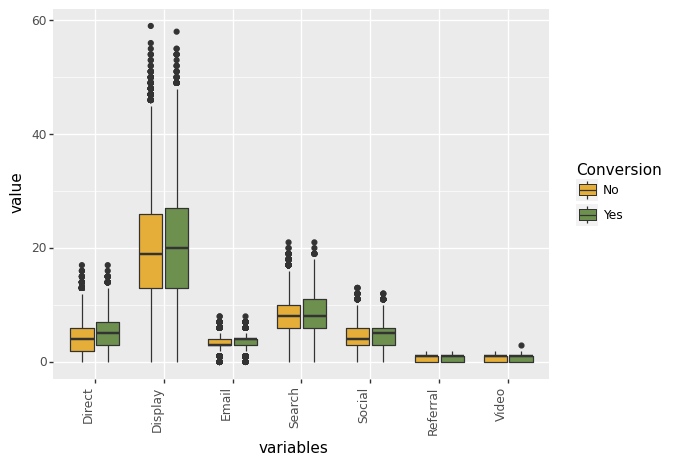

<ggplot: (-9223363254204517474)>

In [ ]:
# Boxplots
flip_xlabels = theme(axis_text_x = element_text(angle=90, hjust=1))
(ggplot(data=d)
 + aes(x='variables', y='value', fill='h_conversion_binary')
 + geom_boxplot()
 + flip_xlabels
 + labs(fill='Conversion')
 + scale_fill_manual(labels= ['No', 'Yes'], values=['#e5ae38', '#6d904f'])
 + scale_x_discrete(labels=['Direct', 'Display', 'Email', 'Search', 'Social', 'Referral', 'Video', 'conversion'])
)

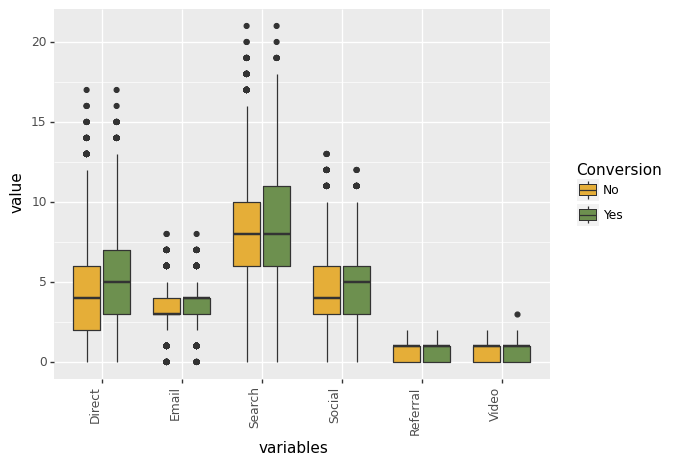

<ggplot: (8782646796927)>

In [ ]:
# Boxplots without `b_display` event
(ggplot(data=d.query('variables != "b_display"'))
 + aes(x='variables', y='value', fill='h_conversion_binary')
 + geom_boxplot()
 + flip_xlabels
 + labs(fill='Conversion')
 + scale_fill_manual(labels= ['No', 'Yes'], values=['#e5ae38', '#6d904f'])
 + scale_x_discrete(labels=['Direct', 'Email', 'Search', 'Social', 'Referral', 'Video', 'conversion'])
)

## Histogram

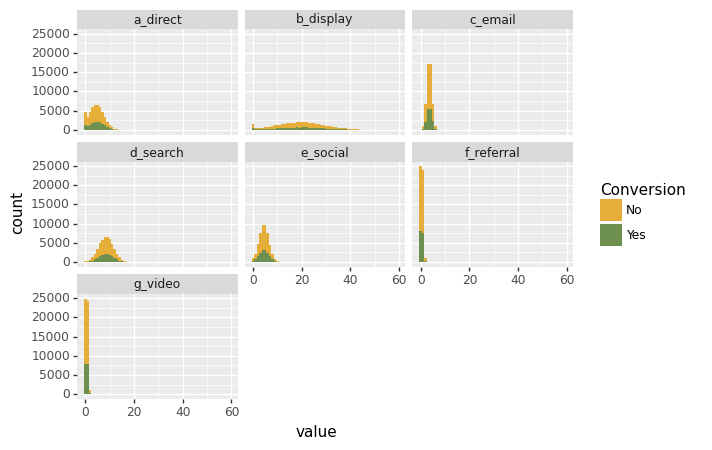

<ggplot: (8782646797046)>

In [ ]:
# Histogram
(ggplot(data=d)
 + aes(x='value', fill='h_conversion_binary')
 + geom_histogram(binwidth=1)
 + labs(fill='Conversion')
 + scale_fill_manual(labels= ['No', 'Yes'], values=['#e5ae38', '#6d904f'])
 + facet_wrap('~variables')
)

## Removing Outliers

In [ ]:
# Removing outliers
variables = ['a_direct', 'b_display', 'c_email', 'd_search', 'e_social', 'f_referral', 'g_video', 'h_conversion']
df_no_outliers = df[variables].copy()
rows_to_remove = (np.abs(stats.zscore(df_no_outliers)) < 3).all(axis=1)
df_no_outliers = df_no_outliers[rows_to_remove]
df_no_outliers['h_conversion_binary'] = df_no_outliers['h_conversion'].map(lambda x: '1' if x > 0 else '0')

In [ ]:
# Stats
print(f'{"# rows with outliers:":<25}{len(df):>6,}')
print(f'{"# rows without outliers:":<25}{len(df_no_outliers):>6,}')
print(f'{"# outliers:":<25}{len(df)-len(df_no_outliers):>6,}')

# rows with outliers:    50,000
# rows without outliers: 49,605
# outliers:                 395


In [ ]:
# Table - Without Outliers
custom_table(df_no_outliers, 'h_conversion')

h_conversion,counts,percentage
0,33739,68.02
2,2540,5.12
3,2649,5.34
4,2678,5.40
5,2671,5.38
6,2609,5.26
7,2719,5.48


In [ ]:
# Table - Without Outliers
custom_table(df_no_outliers, 'h_conversion_binary')

h_conversion_binary,counts,percentage
0,33739,68.02
1,15866,31.98


In [ ]:
# Select variables
variables = ['a_direct', 'b_display', 'c_email', 'd_search', 'e_social', 'f_referral', 'g_video']

# Reshape data for ggplot
d = pd.melt(df_no_outliers, id_vars=['h_conversion_binary'], value_vars=variables, var_name='variables')

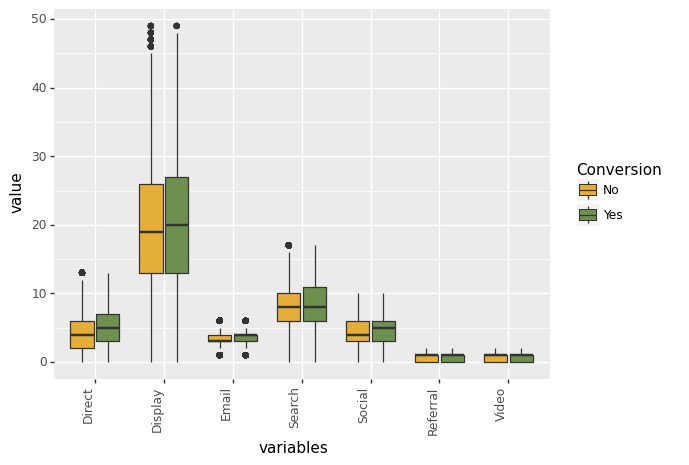

<ggplot: (8782646431734)>

In [ ]:
# Boxplot - Without Outliers
flip_xlabels = theme(axis_text_x = element_text(angle=90, hjust=1))
(ggplot(data=d)
 + aes(x='variables', y='value', fill='h_conversion_binary')
 + geom_boxplot()
 + flip_xlabels
 + labs(fill='Conversion')
 + scale_fill_manual(labels= ['No', 'Yes'], values=['#e5ae38', '#6d904f'])
 + scale_x_discrete(labels=['Direct', 'Display', 'Email', 'Search', 'Social', 'Referral', 'Video', 'conversion'])
)

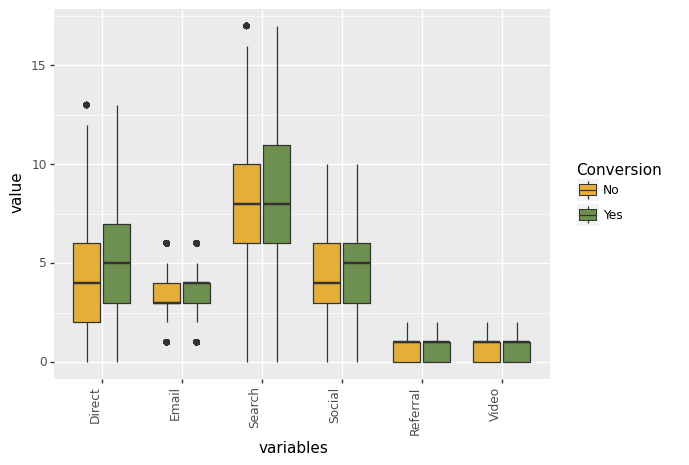

<ggplot: (8782647093950)>

In [ ]:
# Boxplots without `b_display` event - Without Outliers
(ggplot(data=d.query('variables != "b_display"'))
 + aes(x='variables', y='value', fill='h_conversion_binary')
 + geom_boxplot()
 + flip_xlabels
 + labs(fill='Conversion')
 + scale_fill_manual(labels= ['No', 'Yes'], values=['#e5ae38', '#6d904f'])
 + scale_x_discrete(labels=['Direct', 'Email', 'Search', 'Social', 'Referral', 'Video', 'conversion'])
)

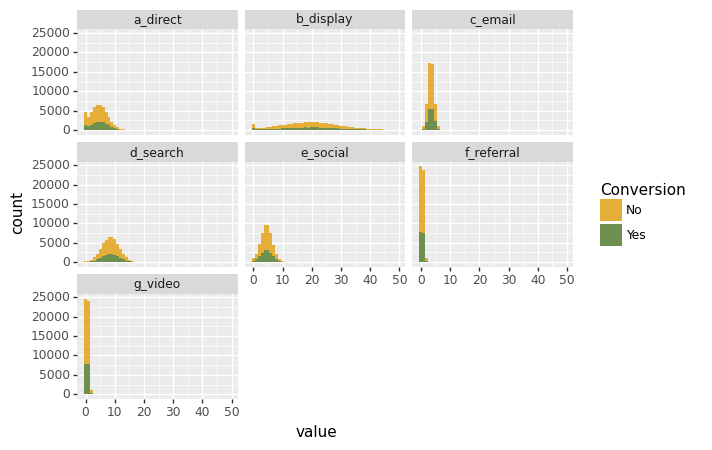

<ggplot: (8782646782584)>

In [ ]:
# Histogram - Without Outliers
(ggplot(data=d)
 + aes(x='value', fill='h_conversion_binary')
 + geom_histogram(binwidth=1)
 + labs(fill='Conversion')
 + scale_fill_manual(labels= ['No', 'Yes'], values=['#e5ae38', '#6d904f'])
 + facet_wrap('~variables')
)

In [ ]:
# # Charts
# ggplot(data=df) + aes(x='a_direct', fill='h_conversion_binary') + geom_histogram(binwidth=1)
# ggplot(data=df) + aes(x='b_display', fill='h_conversion_binary') + geom_histogram(binwidth=1)
# ggplot(data=df) + aes(x='c_email', fill='h_conversion_binary') + geom_histogram(binwidth=1)
# ggplot(data=df) + aes(x='d_search', fill='h_conversion_binary') + geom_histogram(binwidth=1)
# ggplot(data=df) + aes(x='e_social', fill='h_conversion_binary') + geom_histogram(binwidth=1)
# ggplot(data=df) + aes(x='f_referral', fill='h_conversion_binary') + geom_histogram(binwidth=1)
# ggplot(data=df) + aes(x='g_video', fill='h_conversion_binary') + geom_histogram(binwidth=1)

## Correlation Matrix

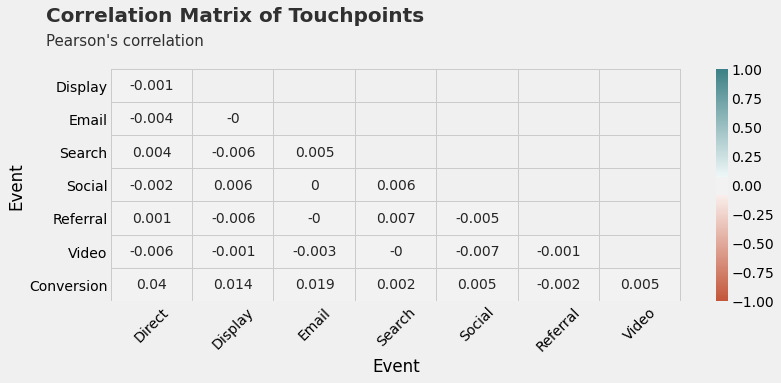

In [ ]:
# Correlation Matrix - With Outliers
_ = custom_corr_plot(df, title='Correlation Matrix of Touchpoints')

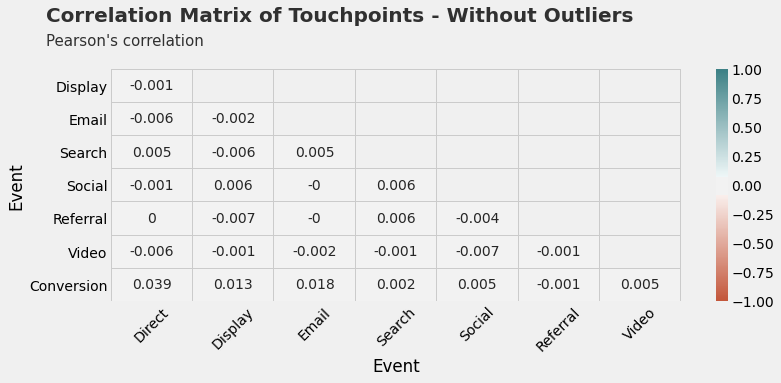

In [ ]:
# Correlation Matrix - Without Outliers
_ = custom_corr_plot(df_no_outliers, title='Correlation Matrix of Touchpoints - Without Outliers')

## Normality Test

In [ ]:
# Test for Normality using Jarque-Bera Test - With Outliers
print(f'  Direct: {custom_normality_test(df["a_direct"])}')
print(f' Display: {custom_normality_test(df["b_display"])}')
print(f'   Email: {custom_normality_test(df["c_email"])}')
print(f'  Search: {custom_normality_test(df["d_search"])}')
print(f'  Social: {custom_normality_test(df["e_social"])}')
print(f'Referral: {custom_normality_test(df["f_referral"])}')
print(f'   Video: {custom_normality_test(df["g_video"])}')

  Direct: {'jb_stat': 937.851405, 'jb_pvalue': 0.0, 'skew': 0.282045, 'kurtosis': 2.63672}
 Display: {'jb_stat': 308.139318, 'jb_pvalue': 0.0, 'skew': 0.127563, 'kurtosis': 2.712219}
   Email: {'jb_stat': 0.273438, 'jb_pvalue': 0.872215, 'skew': -0.001157, 'kurtosis': 2.98878}
  Search: {'jb_stat': 9.681871, 'jb_pvalue': 0.0079, 'skew': 0.024226, 'kurtosis': 2.952044}
  Social: {'jb_stat': 91.577414, 'jb_pvalue': 0.0, 'skew': 0.080197, 'kurtosis': 2.864979}
Referral: {'jb_stat': 3159.076141, 'jb_pvalue': 0.0, 'skew': 0.332351, 'kurtosis': 1.963406}
   Video: {'jb_stat': 3103.16468, 'jb_pvalue': 0.0, 'skew': 0.315564, 'kurtosis': 1.955396}


In [ ]:
# Test for Normality using Jarque-Bera Test - Without Outliers
print(f'  Direct: {custom_normality_test(df_no_outliers["a_direct"])}')
print(f' Display: {custom_normality_test(df_no_outliers["b_display"])}')
print(f'   Email: {custom_normality_test(df_no_outliers["c_email"])}')
print(f'  Search: {custom_normality_test(df_no_outliers["d_search"])}')
print(f'  Social: {custom_normality_test(df_no_outliers["e_social"])}')
print(f'Referral: {custom_normality_test(df_no_outliers["f_referral"])}')
print(f'   Video: {custom_normality_test(df_no_outliers["g_video"])}')

  Direct: {'jb_stat': 977.333909, 'jb_pvalue': 0.0, 'skew': 0.243952, 'kurtosis': 2.515433}
 Display: {'jb_stat': 349.271633, 'jb_pvalue': 0.0, 'skew': 0.101162, 'kurtosis': 2.642158}
   Email: {'jb_stat': 73.077445, 'jb_pvalue': 0.0, 'skew': -0.003417, 'kurtosis': 2.812091}
  Search: {'jb_stat': 49.273735, 'jb_pvalue': 0.0, 'skew': -0.019526, 'kurtosis': 2.850619}
  Social: {'jb_stat': 150.30699, 'jb_pvalue': 0.0, 'skew': 0.033431, 'kurtosis': 2.73875}
Referral: {'jb_stat': 3131.156745, 'jb_pvalue': 0.0, 'skew': 0.333073, 'kurtosis': 1.965025}
   Video: {'jb_stat': 3103.531836, 'jb_pvalue': 0.0, 'skew': 0.313769, 'kurtosis': 1.947502}


In [ ]:
# Test for Normality using Jarque-Bera Test - Without Outliers - Conversion
print('  Direct:', custom_normality_test(df_no_outliers.query('h_conversion_binary == "1"')["a_direct"]))
print(' Display:', custom_normality_test(df_no_outliers.query('h_conversion_binary == "1"')["b_display"]))
print('   Email:', custom_normality_test(df_no_outliers.query('h_conversion_binary == "1"')["c_email"]))
print('  Search:', custom_normality_test(df_no_outliers.query('h_conversion_binary == "1"')["d_search"]))
print('  Social:', custom_normality_test(df_no_outliers.query('h_conversion_binary == "1"')["e_social"]))
print('Referral:', custom_normality_test(df_no_outliers.query('h_conversion_binary == "1"')["f_referral"]))
print('   Video:', custom_normality_test(df_no_outliers.query('h_conversion_binary == "1"')["g_video"]))

  Direct: {'jb_stat': 268.504561, 'jb_pvalue': 0.0, 'skew': 0.194482, 'kurtosis': 2.495158}
 Display: {'jb_stat': 113.909312, 'jb_pvalue': 0.0, 'skew': 0.089282, 'kurtosis': 2.625271}
   Email: {'jb_stat': 28.608844, 'jb_pvalue': 1e-06, 'skew': -0.018928, 'kurtosis': 2.795445}
  Search: {'jb_stat': 23.548697, 'jb_pvalue': 8e-06, 'skew': -0.036986, 'kurtosis': 2.826363}
  Social: {'jb_stat': 50.884245, 'jb_pvalue': 0.0, 'skew': 0.024788, 'kurtosis': 2.727029}
Referral: {'jb_stat': 1006.910734, 'jb_pvalue': 0.0, 'skew': 0.324452, 'kurtosis': 1.950216}
   Video: {'jb_stat': 976.354423, 'jb_pvalue': 0.0, 'skew': 0.302277, 'kurtosis': 1.945764}


In [ ]:
# Test for Normality using Jarque-Bera Test - Without Outliers - Non Conversion
print('  Direct:', custom_normality_test(df_no_outliers.query('h_conversion_binary == "0"')["a_direct"]))
print(' Display:', custom_normality_test(df_no_outliers.query('h_conversion_binary == "0"')["b_display"]))
print('   Email:', custom_normality_test(df_no_outliers.query('h_conversion_binary == "0"')["c_email"]))
print('  Search:', custom_normality_test(df_no_outliers.query('h_conversion_binary == "0"')["d_search"]))
print('  Social:', custom_normality_test(df_no_outliers.query('h_conversion_binary == "0"')["e_social"]))
print('Referral:', custom_normality_test(df_no_outliers.query('h_conversion_binary == "0"')["f_referral"]))
print('   Video:', custom_normality_test(df_no_outliers.query('h_conversion_binary == "0"')["g_video"]))

  Direct: {'jb_stat': 710.998789, 'jb_pvalue': 0.0, 'skew': 0.266927, 'kurtosis': 2.530144}
 Display: {'jb_stat': 235.56761, 'jb_pvalue': 0.0, 'skew': 0.106642, 'kurtosis': 2.650601}
   Email: {'jb_stat': 45.08628, 'jb_pvalue': 0.0, 'skew': 0.003757, 'kurtosis': 2.821072}
  Search: {'jb_stat': 27.33976, 'jb_pvalue': 1e-06, 'skew': -0.011298, 'kurtosis': 2.862387}
  Social: {'jb_stat': 99.700971, 'jb_pvalue': 0.0, 'skew': 0.037502, 'kurtosis': 2.744469}
Referral: {'jb_stat': 2124.853198, 'jb_pvalue': 0.0, 'skew': 0.337098, 'kurtosis': 1.971915}
   Video: {'jb_stat': 2127.31407, 'jb_pvalue': 0.0, 'skew': 0.319187, 'kurtosis': 1.948464}


## Difference tests

The Touchpoints are not normally distributed. Based on this results, we will use Mann-Whitney U test, a nonparametric test, to verify if there is a statistically significant difference between them.

In [ ]:
def custom_sig_test(pvalue):
    return '*' if pvalue < .05 else ''

r = stats.mannwhitneyu(
    df_no_outliers.query('h_conversion_binary == "0"')['a_direct'],
    df_no_outliers.query('h_conversion_binary == "1"')['a_direct']
)
print(f'{"Direct":>9}: stat: {r.statistic:,.0f} - pvalue: {r.pvalue:.4f} {custom_sig_test(r.pvalue)}')

r = stats.mannwhitneyu(
    df_no_outliers.query('h_conversion_binary == "0"')['b_display'],
    df_no_outliers.query('h_conversion_binary == "1"')['b_display']
)
print(f'{"Display":>9}: stat: {r.statistic:,.0f} - pvalue: {r.pvalue:.4f} {custom_sig_test(r.pvalue)}')

r = stats.mannwhitneyu(
    df_no_outliers.query('h_conversion_binary == "0"')['c_email'],
    df_no_outliers.query('h_conversion_binary == "1"')['c_email']
)
print(f'{"Email":>9}: stat: {r.statistic:,.0f} - pvalue: {r.pvalue:.4f} {custom_sig_test(r.pvalue)}')

r = stats.mannwhitneyu(
    df_no_outliers.query('h_conversion_binary == "0"')['d_search'],
    df_no_outliers.query('h_conversion_binary == "1"')['d_search']
)
print(f'{"Search":>9}: stat: {r.statistic:,.0f} - pvalue: {r.pvalue:.4f} {custom_sig_test(r.pvalue)}')

r = stats.mannwhitneyu(
    df_no_outliers.query('h_conversion_binary == "0"')['e_social'],
    df_no_outliers.query('h_conversion_binary == "1"')['e_social']
)
print(f'{"Social":>9}: stat: {r.statistic:,.0f} - pvalue: {r.pvalue:.4f} {custom_sig_test(r.pvalue)}')

r = stats.mannwhitneyu(
    df_no_outliers.query('h_conversion_binary == "0"')['f_referral'],
    df_no_outliers.query('h_conversion_binary == "1"')['f_referral']
)
print(f'{"Referral":>9}: stat: {r.statistic:,.0f} - pvalue: {r.pvalue:.4f} {custom_sig_test(r.pvalue)}')

r = stats.mannwhitneyu(
    df_no_outliers.query('h_conversion_binary == "0"')['g_video'],
    df_no_outliers.query('h_conversion_binary == "1"')['g_video']
)
print(f'{"Video":>9}: stat: {r.statistic:,.0f} - pvalue: {r.pvalue:.4f} {custom_sig_test(r.pvalue)}')
print('\n* There is significant difference (alpha=5%)')

   Direct: stat: 252,647,610 - pvalue: 0.0000 *
  Display: stat: 262,731,762 - pvalue: 0.0005 *
    Email: stat: 260,534,124 - pvalue: 0.0000 *
   Search: stat: 266,135,052 - pvalue: 0.1528 
   Social: stat: 265,132,848 - pvalue: 0.0434 *
 Referral: stat: 267,438,043 - pvalue: 0.4349 
    Video: stat: 266,274,271 - pvalue: 0.1452 

* There is significant difference (alpha=5%)


There is a significant difference between Conversion and Non-Conversion for Direct, Display, Email and Social (Mann-Whitney U test: p-value<5%)

# Logistic Regression

One of the objectives of the study is to identify points of contact that increase the likelihood of conversion. To achieve this goal, we will analyze the chances of conversion (versus non-conversion) using logistic regression. We will first convert the conversion variable into a dichotomous variable. Then, we will fit the logistic regression model. 

## Model with Outliers

In [ ]:
# Model With Outliers
model = smf.glm(
    'h_conversion_binary ~ a_direct + b_display + c_email + d_search + e_social + f_referral + g_video -1',
    data=df,
    family=sm.families.Binomial()
).fit()

print(model.summary2())
print('    Null deviance: %.2f on %d degrees of freedom' % (model.null_deviance, model.nobs))
print('Residual deviance: %.2f on %d degrees of freedom' % (model.deviance, model.df_resid))

                                  Results: Generalized linear model
Model:              GLM                                                  AIC:            63043.2899  
Link Function:      logit                                                BIC:            -477883.8859
Dependent Variable: ['h_conversion_binary[0]', 'h_conversion_binary[1]'] Log-Likelihood: -31515.     
Date:               2020-07-09 14:59                                     LL-Null:        -31350.     
No. Observations:   50000                                                Deviance:       63029.      
Df Model:           6                                                    Pearson chi2:   5.01e+04    
Df Residuals:       49993                                                Scale:          1.0000      
Method:             IRLS                                                                             
-------------------------------------------------------------------------------------------------------------
      

## Model without Outliers

In [ ]:
# Model Without Outliers
model_no_outlier = smf.glm(
    'h_conversion_binary ~ a_direct + b_display + c_email + d_search + e_social + f_referral + g_video -1',
    data=df_no_outliers,
    family=sm.families.Binomial()
).fit()

print(model_no_outlier.summary2())
print('    Null deviance: %.2f on %d degrees of freedom' % (model_no_outlier.null_deviance, model_no_outlier.nobs))
print('Residual deviance: %.2f on %d degrees of freedom' % (model_no_outlier.deviance, model_no_outlier.df_resid))

                                  Results: Generalized linear model
Model:              GLM                                                  AIC:            62513.3847  
Link Function:      logit                                                BIC:            -473746.5986
Dependent Variable: ['h_conversion_binary[0]', 'h_conversion_binary[1]'] Log-Likelihood: -31250.     
Date:               2020-07-09 14:59                                     LL-Null:        -31090.     
No. Observations:   49605                                                Deviance:       62499.      
Df Model:           6                                                    Pearson chi2:   4.97e+04    
Df Residuals:       49598                                                Scale:          1.0000      
Method:             IRLS                                                                             
-------------------------------------------------------------------------------------------------------------
      

## Comparing models

The model without outliers has better AIC (62,513) compared to the model with outliers (63,043).

In [ ]:
# Stats
print(f'AIC - Model with outlier:    {model.aic:,.0f}')
print(f'AIC - Model without outlier: {model_no_outlier.aic:,.0f}')

AIC - Model with outlier:    63,043
AIC - Model without outlier: 62,513


The regression coefficients gives the Odds Ratio that quantifies the strength of the association between the Conversion and the Touchpoints.

If the Odds Ratio is greater than 1, the Conversion probability increase for every one unit change in the touchpoint, holding all other variables constant.





In [ ]:
# Odds Ratio - Model With Outliers
custom_or_model(model).sort_values('Coef.', ascending=False)

,Coef.,2.5%,97.5%
c_email,1.072,1.056,1.088
f_referral,1.064,1.029,1.101
g_video,1.046,1.011,1.082
e_social,1.033,1.024,1.042
d_search,1.032,1.026,1.037
b_display,1.004,1.002,1.006
a_direct,0.986,0.980,0.992


In [ ]:
# Odds Ratio - Model Without Outliers
custom_or_model(model_no_outlier).sort_values('Coef.', ascending=False)

,Coef.,2.5%,97.5%
c_email,1.074,1.058,1.090
f_referral,1.063,1.027,1.100
g_video,1.047,1.012,1.083
e_social,1.033,1.024,1.042
d_search,1.031,1.025,1.037
b_display,1.004,1.002,1.006
a_direct,0.986,0.980,0.992


## Coefficient plot

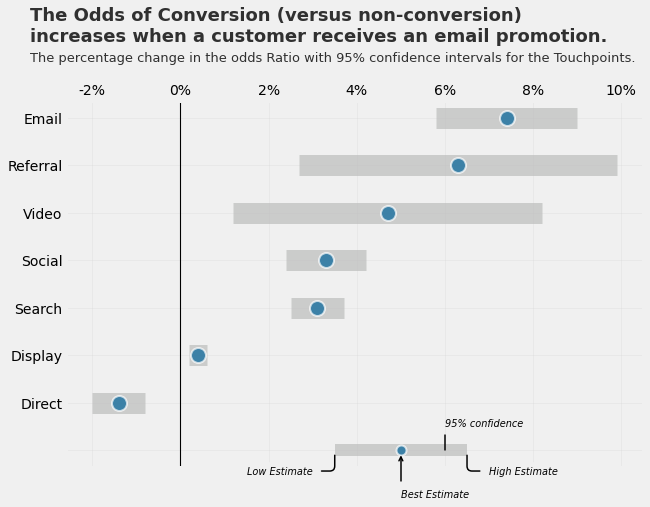

In [ ]:
# Data for Coefficient plot
df_coef = custom_or_model(model_no_outlier)
df_coef['Error'] = df_coef['Coef.'] - df_coef['2.5%']

columns_labels_dict = {
    'a_direct': 'Direct',
    'b_display': 'Display',
    'c_email': 'Email',
    'd_search': 'Search',
    'e_social': 'Social',
    'f_referral': 'Referral',
    'g_video': 'Video',
    'h_conversion': 'Conversion',
}
df_coef['Variables'] = [columns_labels_dict[c] for c in df_coef.index.values]

df_coef = df_coef.sort_values('Coef.')
df_coef = df_coef[['Variables', 'Coef.', 'Error']]

# Data for legend plot
df_explain = pd.DataFrame(
    {
        'Variables': [''],
        'Coef.': [1.05],
        'Error': [.015],
    }
)

# Plot
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10, 7))

# Legend
ax.errorbar(
    y=df_explain['Variables'], x=df_explain['Coef.'], xerr=df_explain['Error'],
    fmt='o', markerfacecolor='#006298', markeredgecolor='white',
    markeredgewidth=2, markersize=10,
    elinewidth=12, alpha=.7, ecolor='#bcbdbc'
)

# Data
ax.errorbar(
    y=df_coef['Variables'], x=df_coef['Coef.'], xerr=df_coef['Error'],
    fmt='o', markerfacecolor='#006298', markeredgecolor='white',
    markeredgewidth=2, markersize=15,
    elinewidth=21, alpha=.7, ecolor='#bcbdbc'
)

# Axis
ax.grid(axis='both', alpha=.2)
ax.axvline(x=1, color='black', lw=1.1, linestyle='-')
f_formatter = ticker.FuncFormatter(lambda t, pos: f'{((t-1)*100):.0f}%')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(f_formatter))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.xaxis.tick_top()

# Annotation
plt.annotate('Best Estimate', style='italic', fontsize='x-small',
             xy=(1.05, 0), xycoords='data',
             xytext=(1.05, -1), textcoords='data',
             arrowprops=dict(arrowstyle="->", color="black", lw=1.5,
                            shrinkA=5, shrinkB=5,
                            connectionstyle="angle,angleA=180,angleB=90,rad=5",
                            ),
             backgroundcolor='#f0f0f0'
            )
plt.annotate('High Estimate', style='italic', fontsize='x-small',
             xy=(1.065, 0), xycoords='data',
             xytext=(1.07, -.5), textcoords='data',
             arrowprops=dict(arrowstyle="-", color="black", lw=1.5,
                            shrinkA=5, shrinkB=5,
                            connectionstyle="angle,angleA=180,angleB=90,rad=5",
                            ),
             backgroundcolor='#f0f0f0'
            )
plt.annotate('Low Estimate', style='italic', fontsize='x-small',
             xy=(1.035, 0), xycoords='data',
             xytext=(1.015, -.5), textcoords='data',
             arrowprops=dict(arrowstyle="-", color="black", lw=1.5,
                            shrinkA=5, shrinkB=5,
                            connectionstyle="angle,angleA=180,angleB=90,rad=5",
                            ),
             backgroundcolor='#f0f0f0'
            )
plt.annotate('95% confidence',  style='italic', fontsize='x-small',
             xy=(1.06, -.1), xycoords='data',
             xytext=(1.06, .5), textcoords='data',
             arrowprops=dict(arrowstyle="-", color="black", lw=1.5,
                            shrinkA=5, shrinkB=5,
                            connectionstyle="angle,angleA=180,angleB=90,rad=5",
                            )
            )
# Title
title = 'The Odds of Conversion (versus non-conversion) ' \
        '\nincreases when a customer receives an email promotion.'
subtitle = 'The percentage change in the odds Ratio ' \
           'with 95% confidence intervals for the Touchpoints.'

plt.gcf().text(0.09, 1, title, fontsize=18, weight='bold', alpha=.8)
plt.gcf().text(0.09, .96, subtitle, fontsize=13, alpha=.8)
plt.tight_layout(pad=3)

We can see that Email, Referral and Video has the greater Odds ratios estimated. The Referral and Video has the biggest variation estimated.

# Nexts steps 

Based on this study, we recommend:

*  A campaign based on Email.
*  Deep study for the Referral and Video touchpoints, for example, which sites the Customers interacted with these events.
*  Deep study for Direct touchpoint, for example, the Customers navigate directly on the website searching for promotions or product price reduction.
*  Check which touchpoints make the Customer buy more.

